## Objective

According to the National Survey of Drug Use and Health's 2017 annual report, approximatly 19.7 million Americans over the age of 12 suffer from a substance use disorder. Substance use disoders are defined by the Diagnostic and Statistical Manual of Mental Disorders (DSM-5) as occuring when an individual struggles with at least 2 of their specified 11 symptoms, and said individual is unable to stop using despite the negative impact that using has on their life.

DSM-5 criteria:
- Taking the substance in larger amounts or for longer than you're meant to.
- Wanting to cut down or stop using the substance but not managing to.
- Spending a lot of time getting, using, or recovering from use of the substance.
- Cravings and urges to use the substance.
- Not managing to do what you should at work, home, or school because of substance use.
- Continuing to use, even when it causes problems in relationships.
- Giving up important social, occupational, or recreational activities because of substance use.
- Using substances again and again, even when it puts you in danger.
- Continuing to use, even when you know you have a physical or psychological problem that could have been caused or made worse by the substance.
- Needing more of the substance to get the effect you want (tolerance).
- Development of withdrawal symptoms, which can be relieved by taking more of the substance.

Despite the high number of people who fit the criteria for having a substance use disorder, only about 20% of sufferers go into treatment for their issue. There are multiple possible reasons as to why this is such an undertreated population, especially since so many people who suffer the most fall though the cracks of society, often dealing with additional issues such as severe mental illness, poverty, and homelessness.

The purpose of this project is to identify the differences between people who seek professional help for their substance problems and similarly affected people who go on untreated.

In which areas do afflicted people who seek treatment differ from those who don’t?


I will be mainly focusing on demographic features in predicting whether or not someone receives treatment or not:
- gender
- age
- education level
- household income
- criminal history

Along with features looking at possibly comorbid mental health concerns:
- having had a major depressive episode
- having excessively high levels of anxiety
- having gone through a traumatic experience
- showing manic symptoms

And a few others related to receiving treatment:
- whether or not an individual has already received mental health treatment
- healthcare coverage
- type of substance abused

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 150)
plt.style.use('bmh')
from IPython.display import display


In [2]:
def confusion_matrix_stats(model, x, y):
    """Given a model, x, and y values the function returns 
    a confusion matrix table and percentage of Type I and 
    Type II errors.  Function can return a single matrix or two 
    matrices for comparing train and test sets.  
    Input for confusion matrix stats for both train and test sets
    is as follows:
     
        confusion_matrix_stats(model, [X_train, X_test], [y_train, y_test])
     
     To avoid confusion when reading matrices and error stats, order entry of 
     train and test should be observed; 'train' sets should preceed 'test' sets."""

    if len(x) > 2:
        predict = model.predict(x)
        table = pd.crosstab(y, predict, margins=True)
        tI = table.loc[0.0, 1.0] / table.loc['All', 'All']
        tII = table.loc[1.0, 0.0] / table.loc['All', 'All']

        print(('----- Confusion Matrix -----\n' 
               f'{table}\n' '\n' f'Accuracy:\n' 
               f'Percent Type I errors: {tI}\n' 
               f'Percent Type II errors: {tII}\n'))

    else:
        splits = ['Train set', 'Test set']
        for i,split in enumerate(x):
            predict = model.predict(split)
            table = pd.crosstab(y[i], predict, margins=True)
            tI = table.loc[0.0, 1.0] / table.loc['All', 'All']
            tII = table.loc[1.0, 0.0] / table.loc['All', 'All']

            print(('\n' f'----- {splits[i]} Confusion Matrix -----\n' 
                   f'{table}\n' '\n' 
                   f'----- {splits[i]} Accuracy -----\n' 
                   f'Percent Type I errors: {tI}\n' 
                   f'Percent Type II errors: {tII}\n'))

## Import dataset

In preparing the dataset, I will:
- filter the data to only contain responses from individulas who had a substance use disorder
- ensure that my categories are binary
- ensure that there are no null values

In [3]:
df = pd.read_csv('mh-aldr-cr-data.tsv.csv')

In [4]:
#Create a filtered dataset of respondents that have an alcohol or drug dependence or abuse problem
fd = df.copy()
fd = fd.loc[fd['ABODILAL'] == 1]

In [5]:
#Seperate variables of interest into groups
#Wher
subtx = fd[['TREATMENTLT']]
#History of mental health treatment
mhtx = fd[[ 'ANYYA']]
#History with substance abuse prevention programs in school
prvprg = fd[['ANYEDUC3']]
#History of extremely distressing life experiences
stress = fd[['PTSEVER']]
#Having more than a high school education/ being presently enrolled in school
sch = fd[['EDU_DUMMY', 'SCHOOL']]
#History of social anxiety, general anxiety, and panic attacks
anx = fd[['PHBSOCL', 'GADNRVOS', 'PANATAK']]
#Healthcare type: medicare, medicaid, military, or private through employer
hthcr = fd[['MEDICARE', 'CAIDCHIP', 'CHAMPUS', 'GRPHLTIN']]
#Criminal history
crm = fd[['ANYCRIME']]
#History of a depressive episode
dep = fd[['DEPEPISODE']]
#Type of substance abused
abudep = fd[[ 'ABODALC', 'ABODANL', 'ABODCOC', 'ABODHAL', 'ABODHER', 'ABODINH', 'ABODMRJ', 'ABODSED', 'ABODSTM', 'ABODTRN' ]]
#Household income level
inc = pd.get_dummies(fd['TOTFAMINCOME'], prefix= 'INCOME')
#Gender
gnd = fd[['FEMALE']]

In [6]:
#Ensure that variables are binary - force negative responses to be 0
for col in subtx.columns:
    subtx[col].loc[subtx[col] != 1] = 0

In [7]:
#Combine selected variables into one dataframe
tx_df = pd.DataFrame()
tx_df = pd.concat([mhtx, prvprg, hthcr, crm, stress, dep, anx, sch, inc, gnd, abudep], axis = 1)

In [8]:
#Ensure that variables are binary - force negative responses to be 0
for col in tx_df.columns:
    tx_df[col].loc[tx_df[col] != 1] = 0

In [9]:
#Handle special cases
fd['MNCEVER'].loc[fd['MNCEVER'] == 5] = 1
fd['MNCEVER'].loc[fd['MNCEVER'] != 1] = 0

#History of a manic episode
mnc = fd[['MNCEVER']]

#Age of respondent in years
age = fd[['AGE_YRS']]

In [10]:
#Add treated special cases to final dataaframe
tx_df = pd.concat([tx_df, mnc, age], axis = 1)

In [11]:
for col in tx_df.columns:
    print(tx_df[col].value_counts())

0    5550
1    1798
Name: ANYYA, dtype: int64
0    6199
1    1149
Name: ANYEDUC3, dtype: int64
0    7245
1     103
Name: MEDICARE, dtype: int64
0    6350
1     998
Name: CAIDCHIP, dtype: int64
0    7162
1     186
Name: CHAMPUS, dtype: int64
1    4032
0    3316
Name: GRPHLTIN, dtype: int64
0    5263
1    2085
Name: ANYCRIME, dtype: int64
0    6070
1    1278
Name: PTSEVER, dtype: int64
0    6071
1    1277
Name: DEPEPISODE, dtype: int64
0    6538
1     810
Name: PHBSOCL, dtype: int64
0    7099
1     249
Name: GADNRVOS, dtype: int64
0    6614
1     734
Name: PANATAK, dtype: int64
0    4698
1    2650
Name: EDU_DUMMY, dtype: int64
0    3853
1    3495
Name: SCHOOL, dtype: int64
0    6190
1    1158
Name: INCOME_1, dtype: int64
0    6205
1    1143
Name: INCOME_2, dtype: int64
0    6396
1     952
Name: INCOME_3, dtype: int64
0    6529
1     819
Name: INCOME_4, dtype: int64
0    6526
1     822
Name: INCOME_5, dtype: int64
0    6267
1    1081
Name: INCOME_6, dtype: int64
0    5975
1    1373
Name: 

In [12]:
tx_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7348 entries, 3 to 55598
Data columns (total 34 columns):
ANYYA         7348 non-null int64
ANYEDUC3      7348 non-null int64
MEDICARE      7348 non-null int64
CAIDCHIP      7348 non-null int64
CHAMPUS       7348 non-null int64
GRPHLTIN      7348 non-null int64
ANYCRIME      7348 non-null int64
PTSEVER       7348 non-null int64
DEPEPISODE    7348 non-null int64
PHBSOCL       7348 non-null int64
GADNRVOS      7348 non-null int64
PANATAK       7348 non-null int64
EDU_DUMMY     7348 non-null int64
SCHOOL        7348 non-null int64
INCOME_1      7348 non-null int64
INCOME_2      7348 non-null int64
INCOME_3      7348 non-null int64
INCOME_4      7348 non-null int64
INCOME_5      7348 non-null int64
INCOME_6      7348 non-null int64
INCOME_7      7348 non-null int64
FEMALE        7348 non-null int64
ABODALC       7348 non-null int64
ABODANL       7348 non-null int64
ABODCOC       7348 non-null int64
ABODHAL       7348 non-null int64
ABODHER 

## Substance treatment

Here we can see that only about 20% of people with a substance use problem seek treatment within their life time.

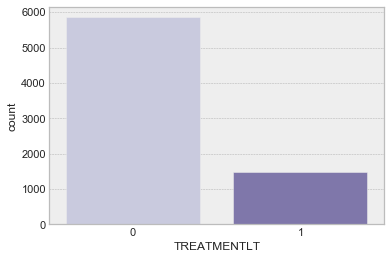

In [13]:
sns.countplot(subtx['TREATMENTLT'], palette= 'Purples')
plt.show()


In [14]:
subtx.describe()

,TREATMENTLT
count,7348.000000
mean,0.202912
std,0.402195
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Mental health treatment

Here we can see that people with a history of any type of mental health treatment received substance abuse treatment at a higher proportion than those without such history.

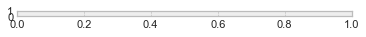

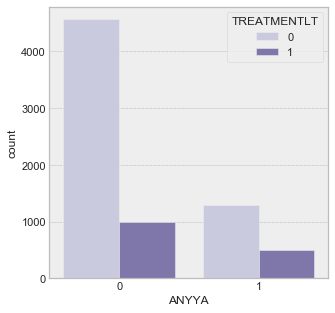

In [15]:
for col in mhtx:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()


In [16]:
tx_df[mhtx.columns].describe()

,ANYYA
count,7348.000000
mean,0.244692
std,0.429934
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Substances

Looking at type of substance abused we see high numbers of people with problems with alcohol and marijuana. We also see that people with alochol problems are more likely to receive treatment than those with a different type of substance issue.

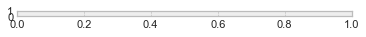

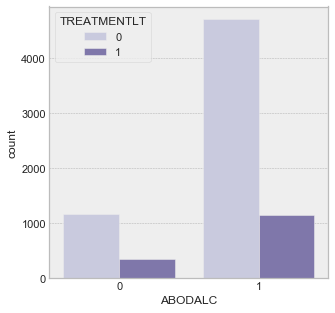

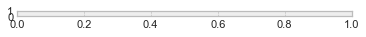

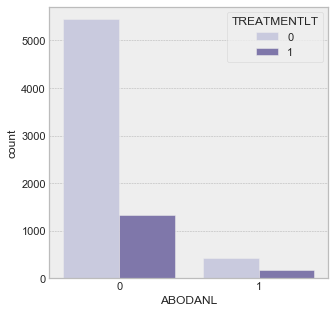

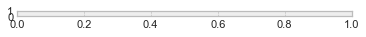

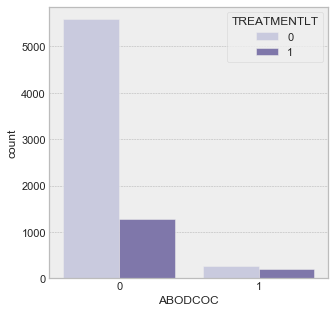

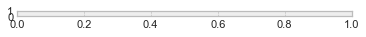

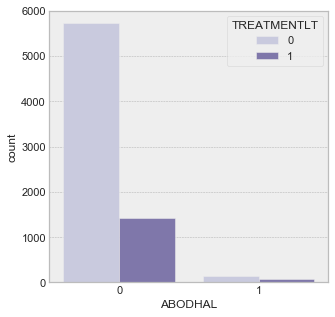

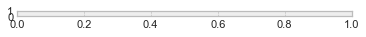

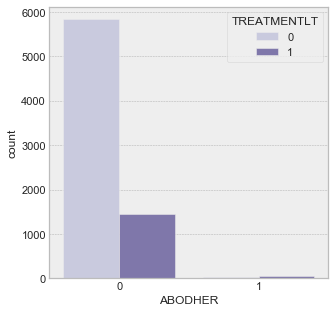

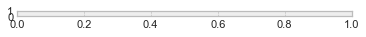

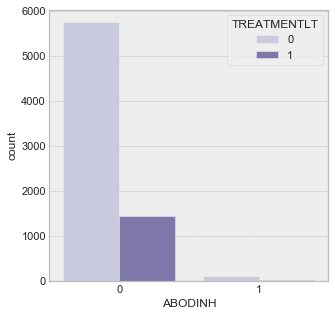

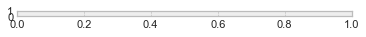

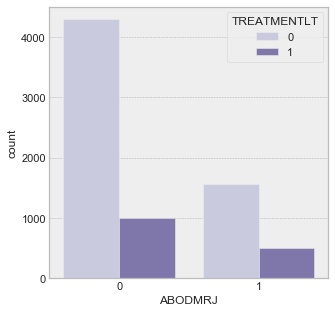

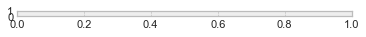

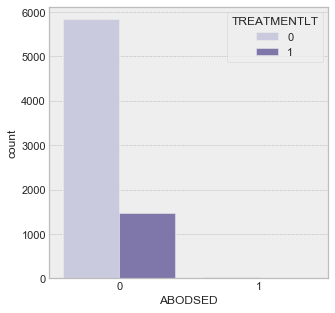

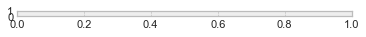

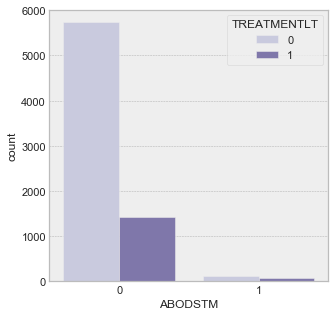

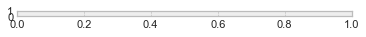

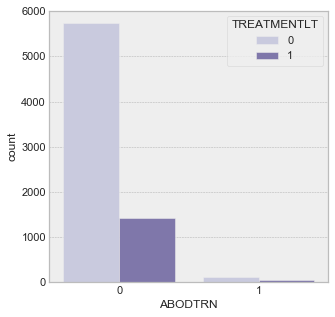

In [17]:
for col in abudep:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [18]:
tx_df[abudep.columns].describe()

,ABODALC,ABODANL,ABODCOC,ABODHAL,ABODHER,ABODINH,ABODMRJ,ABODSED,ABODSTM,ABODTRN
count,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000
mean,0.795591,0.079886,0.065188,0.029260,0.010615,0.019461,0.280348,0.005171,0.026130,0.025449
std,0.403297,0.271135,0.246874,0.168545,0.102488,0.138148,0.449200,0.071732,0.159531,0.157495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Prevention Programs

Looking at the plot we don't see much an effect from prevention programs.

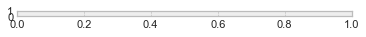

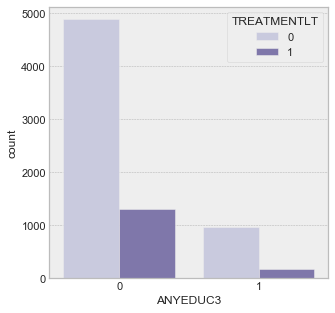

In [19]:
for col in prvprg:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [20]:
tx_df[prvprg.columns].describe()

,ANYEDUC3
count,7348.000000
mean,0.156369
std,0.363230
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Healthcare

Looking at the plots we see that people who are under a private healthcare plan via an employer received treatment more often those covered by other forms of healthcare.

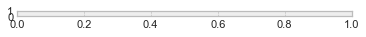

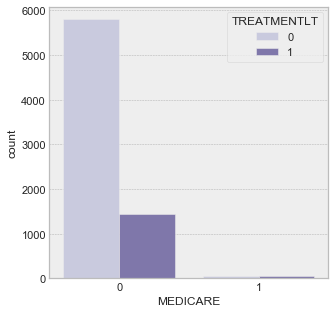

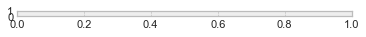

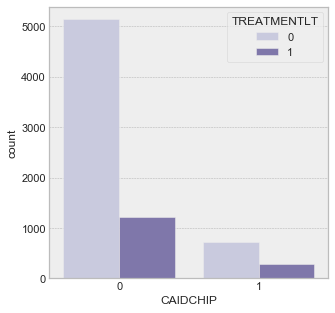

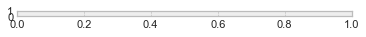

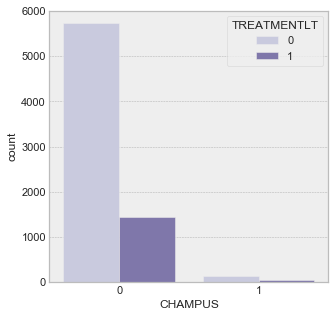

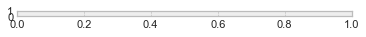

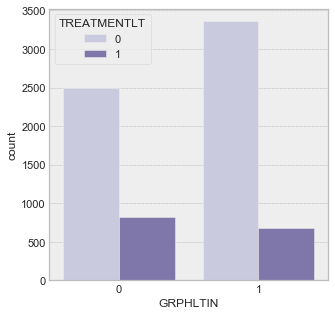

In [21]:
for col in hthcr:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [22]:
tx_df[hthcr.columns].describe()

,MEDICARE,CAIDCHIP,CHAMPUS,GRPHLTIN
count,7348.000000,7348.000000,7348.000000,7348.000000
mean,0.014017,0.135819,0.025313,0.548721
std,0.117570,0.342620,0.157085,0.497654
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


## Crime

Respondents with a criminal history received treatment at a higher proportion than those without a criminal history.

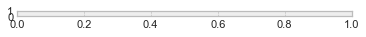

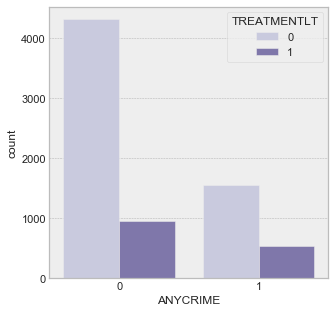

In [23]:
for col in crm:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [24]:
tx_df[crm.columns].describe()

,ANYCRIME
count,7348.000000
mean,0.283751
std,0.450848
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Stress

Here we see a slight effect of a stressful experience on receiving substance abuse treatment.

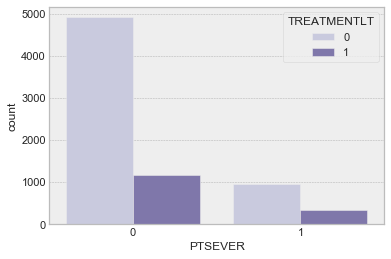

In [25]:
sns.countplot(tx_df['PTSEVER'], hue = fd['TREATMENTLT'], palette= 'Purples')

In [26]:
tx_df[stress.columns].describe()

,PTSEVER
count,7348.000000
mean,0.173925
std,0.379071
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Depression

Here we see a slight effect of a depressive episode on receiving substance abuse treatment.

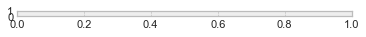

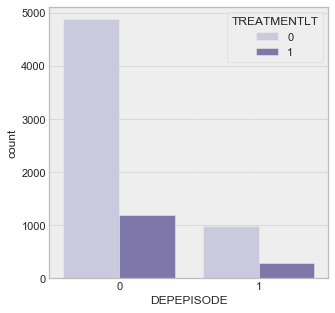

In [27]:
for col in dep:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [28]:
tx_df[dep.columns].describe()

,DEPEPISODE
count,7348.000000
mean,0.173789
std,0.378954
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Anxiety

Here we see a slight effect of a history with anxiety on receiving substance abuse treatment.

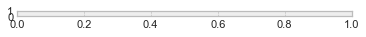

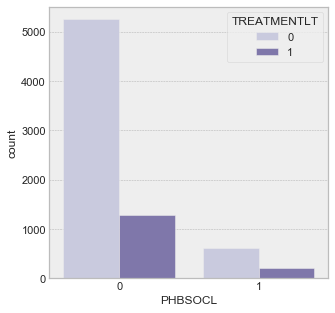

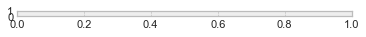

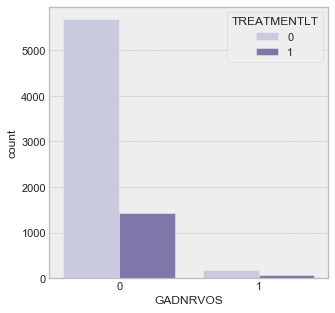

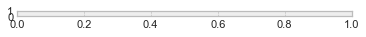

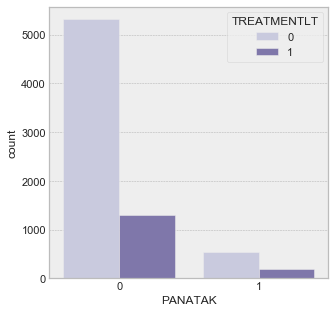

In [29]:
for col in anx:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [30]:
tx_df[anx.columns].describe()

,PHBSOCL,GADNRVOS,PANATAK
count,7348.000000,7348.000000,7348.000000
mean,0.110234,0.033887,0.099891
std,0.313203,0.180950,0.299875
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


## Mania

Here we see a slight effect of a manic episode on receiving substance abuse treatment.

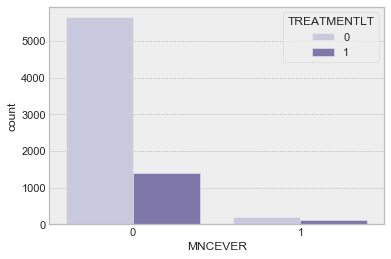

In [31]:
sns.countplot(tx_df['MNCEVER'], hue = fd['TREATMENTLT'], palette= 'Purples')
plt.show()

In [32]:
tx_df[mnc.columns].describe()

,MNCEVER
count,7348.000000
mean,0.042461
std,0.201651
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Education

It looks as if being currently enrolled in school has a higher effect on whether or not one receives treatment than having a post-secondary education.

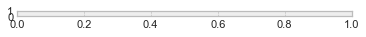

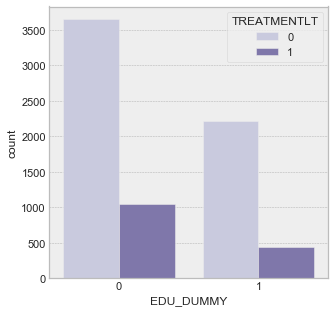

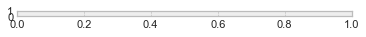

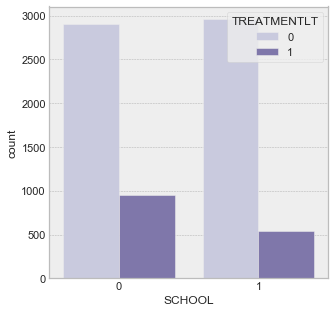

In [33]:
for col in sch:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [34]:
tx_df[sch.columns].describe()

,EDU_DUMMY,SCHOOL
count,7348.000000,7348.00000
mean,0.360642,0.47564
std,0.480220,0.49944
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,1.00000
max,1.000000,1.00000


## Age

We see an interesting trend here where people are more likely to suffere from a substance problem whne in their early-twenties, but are more likely to seek treatment when in their mid-thirties.

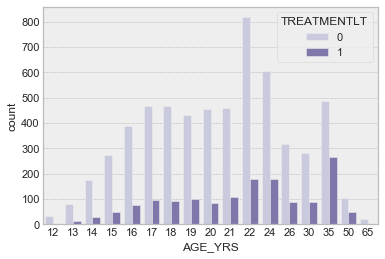

In [35]:
sns.countplot(tx_df['AGE_YRS'], hue = fd['TREATMENTLT'], palette= 'Purples')
plt.show()

In [36]:
tx_df[age.columns].describe()

,AGE_YRS
count,7348.000000
mean,22.700054
std,7.457378
min,12.000000
25%,18.000000
50%,21.000000
75%,24.000000
max,65.000000


## Income

Here we see a slight effect of aincome level on receiving substance abuse treatment.

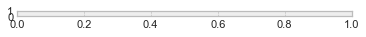

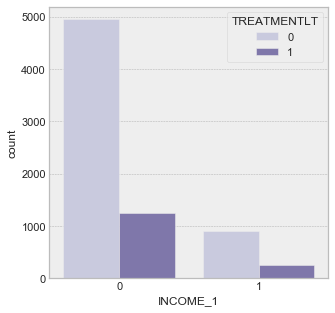

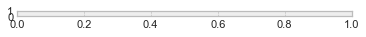

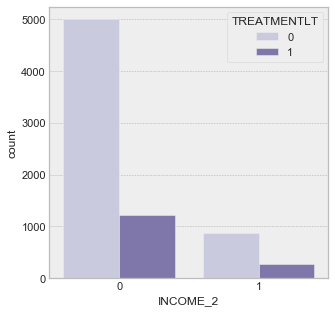

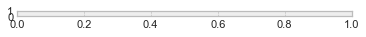

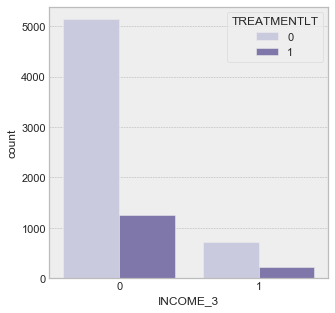

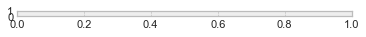

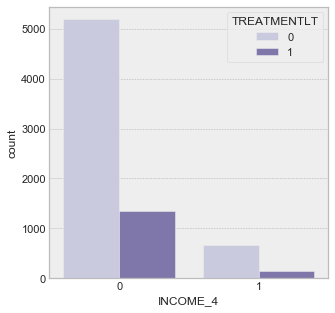

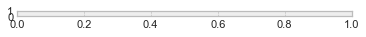

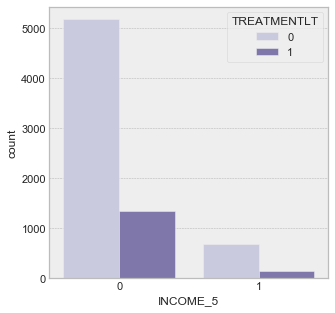

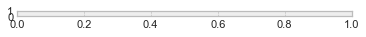

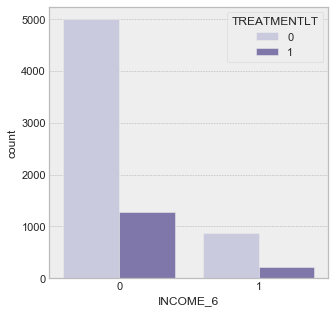

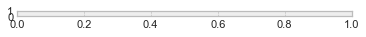

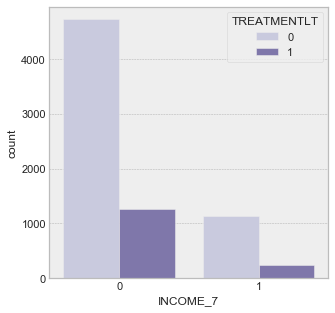

In [37]:
for col in inc:
    plt.subplot(len(tx_df.columns),1, (tx_df.columns.get_loc(col)+1))
    plt.figure(figsize = (5,5))
    sns.countplot(tx_df[col], hue = fd['TREATMENTLT'], palette= 'Purples')
    plt.show()

In [38]:
tx_df[inc.columns].describe()

,INCOME_1,INCOME_2,INCOME_3,INCOME_4,INCOME_5,INCOME_6,INCOME_7
count,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000
mean,0.157594,0.155553,0.129559,0.111459,0.111867,0.147115,0.186854
std,0.364385,0.362455,0.335841,0.314721,0.315224,0.354244,0.389820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Gender

Here we see an effect that gender has on recieving substance abuse treatment, with men being more likely to receive than women.

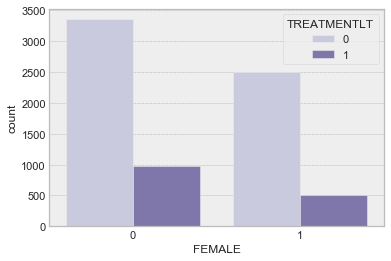

In [39]:
sns.countplot(tx_df['FEMALE'], hue = fd['TREATMENTLT'], palette= 'Purples')
plt.show()

In [40]:
tx_df[gnd.columns].describe()

,FEMALE
count,7348.000000
mean,0.409907
std,0.491850
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Multicolinearity

Here I make sure that the features don't have excessive correlations with each other.

In [41]:
import itertools

list_to_append_to = []
for a, b in list(itertools.combinations(tx_df.columns,2)): 
    list_to_append_to.append([a, b, tx_df[a].corr(tx_df[b])])

df1 = pd.DataFrame(list_to_append_to, columns=['variable_one', 'variable_two', 'correlation'])
df1 = df1.sort_values(by='correlation', ascending=False)

In [42]:
df1

,variable_one,variable_two,correlation
44,ANYEDUC3,SCHOOL,0.419776
213,PTSEVER,PANATAK,0.378776
262,PHBSOCL,PANATAK,0.374018
211,PTSEVER,PHBSOCL,0.329162
513,ABODANL,ABODTRN,0.287062
350,EDU_DUMMY,AGE_YRS,0.284287
328,PANATAK,MNCEVER,0.280984
234,PTSEVER,MNCEVER,0.279085
204,ANYCRIME,ABODMRJ,0.268478
95,MEDICARE,AGE_YRS,0.265911


# Model Selection

In [44]:
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

#Define features and target variables
X = tx_df
y = fd['TREATMENTLT']

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 21)


Since my target variable is unblanced (only about 20% of respondents gave a positive response), I'm going to balance out my dataset through oversampling. 


In [45]:
sm = SMOTE(random_state=12)

X_res,y_res = sm.fit_resample(X_train,y_train)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res,y_res,test_size=.2,random_state=21)

In [46]:
#Target variable is now balanced

y_train_res.mean()

0.5012698837053869

## KNNeighbors Classifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train_res, y_train_res)

print(knn.score(X_train_res, y_train_res), knn.score(X_test_res, y_test_res))


0.8151316668894533 0.7450561197220738


In [48]:
print(np.mean(cross_val_score(knn, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(knn, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(knn, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.7099311378462208
0.6694021153850757
0.8330666666666667


In [49]:
confusion_matrix_stats(knn, [X_train_res,  X_test_res], [y_train_res, y_test_res])


----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      2720  1011  3731
1       372  3378  3750
All    3092  4389  7481

----- Train set Accuracy -----
Percent Type I errors: 0.13514236064697233
Percent Type II errors: 0.04972597246357439


----- Test set Confusion Matrix -----
col_0    0     1   All
row_0                 
0      608   337   945
1      140   786   926
All    748  1123  1871

----- Test set Accuracy -----
Percent Type I errors: 0.18011758417958312
Percent Type II errors: 0.07482629609834313



## Decision Tree Classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

dtc.fit(X_train_res, y_train_res)

dtc.score(X_train_res, y_train_res), dtc.score(X_test_res, y_test_res)

(0.9435904290870204, 0.7600213789417424)

In [51]:
print(np.mean(cross_val_score(dtc, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(dtc, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(dtc, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.7418796688466278
0.7203351986812153
0.7792


In [52]:
confusion_matrix_stats(dtc, [X_train_res,  X_test_res], [y_train_res, y_test_res])


----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      3491   240  3731
1       182  3568  3750
All    3673  3808  7481

----- Train set Accuracy -----
Percent Type I errors: 0.03208127255714477
Percent Type II errors: 0.02432829835583478


----- Test set Confusion Matrix -----
col_0    0     1   All
row_0                 
0      674   271   945
1      178   748   926
All    852  1019  1871

----- Test set Accuracy -----
Percent Type I errors: 0.1448423303046499
Percent Type II errors: 0.0951362907536077



## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train_res, y_train_res)

rfc.score(X_train_res, y_train_res), rfc.score(X_test_res, y_test_res)

(0.9357037829167224, 0.7888829502939605)

In [54]:
print(np.mean(cross_val_score(rfc, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(rfc, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(rfc, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.7531061310080415
0.757038782968621
0.7792


In [55]:
confusion_matrix_stats(rfc, [X_train_res,  X_test_res], [y_train_res, y_test_res])


----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      3443   288  3731
1       193  3557  3750
All    3636  3845  7481

----- Train set Accuracy -----
Percent Type I errors: 0.03849752706857372
Percent Type II errors: 0.025798690014703918


----- Test set Confusion Matrix -----
col_0    0    1   All
row_0                
0      732  213   945
1      182  744   926
All    914  957  1871

----- Test set Accuracy -----
Percent Type I errors: 0.11384286477819348
Percent Type II errors: 0.09727418492784608



## Gradient Boosting Classifier

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
                            

gbc.fit(X_train_res, y_train_res)

gbc.score(X_train_res, y_train_res), gbc.score(X_test_res, y_test_res)

(0.7232990241946264, 0.7161945483698557)

In [57]:
print(np.mean(cross_val_score(gbc, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(gbc, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(gbc, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.7049845957346702
0.7187721973090234
0.6770666666666667


In [58]:
confusion_matrix_stats(gbc, [X_train_res,  X_test_res], [y_train_res, y_test_res])


----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      2827   904  3731
1      1166  2584  3750
All    3993  3488  7481

----- Train set Accuracy -----
Percent Type I errors: 0.12083945996524528
Percent Type II errors: 0.15586151584012833


----- Test set Confusion Matrix -----
col_0    0    1   All
row_0                
0      701  244   945
1      287  639   926
All    988  883  1871

----- Test set Accuracy -----
Percent Type I errors: 0.13041154462854088
Percent Type II errors: 0.1533939070016034



## Support Vector Classifier

In [59]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train_res , y_train_res)

svm.score(X_train_res, y_train_res), svm.score(X_test_res, y_test_res)

(0.7204919128458762, 0.7161945483698557)

In [60]:
print(np.mean(cross_val_score(svm, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(svm, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(svm, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.695761443991854
0.7108511796294165
0.6642666666666667


In [61]:
confusion_matrix_stats(svm, [X_train_res,  X_test_res], [y_train_res, y_test_res])


----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      2856   875  3731
1      1216  2534  3750
All    4072  3409  7481

----- Train set Accuracy -----
Percent Type I errors: 0.1169629728645903
Percent Type II errors: 0.16254511428953347


----- Test set Confusion Matrix -----
col_0     0    1   All
row_0                 
0       720  225   945
1       306  620   926
All    1026  845  1871

----- Test set Accuracy -----
Percent Type I errors: 0.12025654730090861
Percent Type II errors: 0.1635489043292357



## Logistic Regression Classifier

In [62]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_res, y_train_res)

lr.score(X_train_res, y_train_res), lr.score(X_test_res, y_test_res)

(0.7036492447533752, 0.703901656867985)

In [63]:
print(np.mean(cross_val_score(lr, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(lr, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(lr, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.6989705899855602
0.718591658223307
0.6568


In [64]:
confusion_matrix_stats(lr, [X_train_res,  X_test_res], [y_train_res, y_test_res])



----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      2803   928  3731
1      1289  2461  3750
All    4092  3389  7481

----- Train set Accuracy -----
Percent Type I errors: 0.12404758722095977
Percent Type II errors: 0.172303168025665


----- Test set Confusion Matrix -----
col_0     0    1   All
row_0                 
0       713  232   945
1       322  604   926
All    1035  836  1871

----- Test set Accuracy -----
Percent Type I errors: 0.12399786210582577
Percent Type II errors: 0.17210048102618922



## Dummy Classifier

In [65]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy = 'most_frequent')

dummy.fit(X_train_res, y_train_res)

dummy.score(X_train_res, y_train_res),dummy.score(X_test_res, y_test_res)


(0.5012698837053869, 0.4949225013361839)

In [66]:
print(np.mean(cross_val_score(dummy, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(dummy, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(dummy, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.5012699016213588
0.5012699016213588
1.0


## Parameter tuning

In [77]:
from sklearn.model_selection import GridSearchCV


parameters = {'max_features':[12, 13, 14],
              'n_estimators':[1000],
              'min_samples_leaf': [1, 2, 3],
              'max_depth' : [20, 40, 50, 70]}

random_grid = GridSearchCV(rfc, parameters, cv = 5)

In [78]:
random_grid.fit(X_train_res, y_train_res)

random_grid.best_params_

{'max_depth': 50,
 'max_features': 14,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [79]:
rfc_o = RandomForestClassifier(max_features = 'sqrt', min_samples_leaf =  1, n_estimators =  1000, max_depth= 20)

rfc_o.fit(X_train_res, y_train_res)

rfc_o.score(X_train_res, y_train_res), rfc_o.score(X_test_res, y_test_res)

(0.9369068306376153, 0.806520577231427)

In [70]:
print(np.mean(cross_val_score(rfc_o, X_train_res, y_train_res,cv = 3, scoring='accuracy')))
print(np.mean(cross_val_score(rfc_o, X_train_res, y_train_res,cv = 3, scoring='precision')))
print(np.mean(cross_val_score(rfc_o, X_train_res, y_train_res,cv = 3, scoring='recall')))

0.7798418303138658
0.7653267573630517
0.8064


In [71]:
confusion_matrix_stats(rfc_o, [X_train_res,  X_test_res], [y_train_res, y_test_res])


----- Train set Confusion Matrix -----
col_0     0     1   All
row_0                  
0      3438   293  3731
1       129  3621  3750
All    3567  3914  7481

----- Train set Accuracy -----
Percent Type I errors: 0.03916588691351423
Percent Type II errors: 0.017243683999465312


----- Test set Confusion Matrix -----
col_0    0    1   All
row_0                
0      732  213   945
1      154  772   926
All    886  985  1871

----- Test set Accuracy -----
Percent Type I errors: 0.11384286477819348
Percent Type II errors: 0.08230892570817744



## Feature Importances

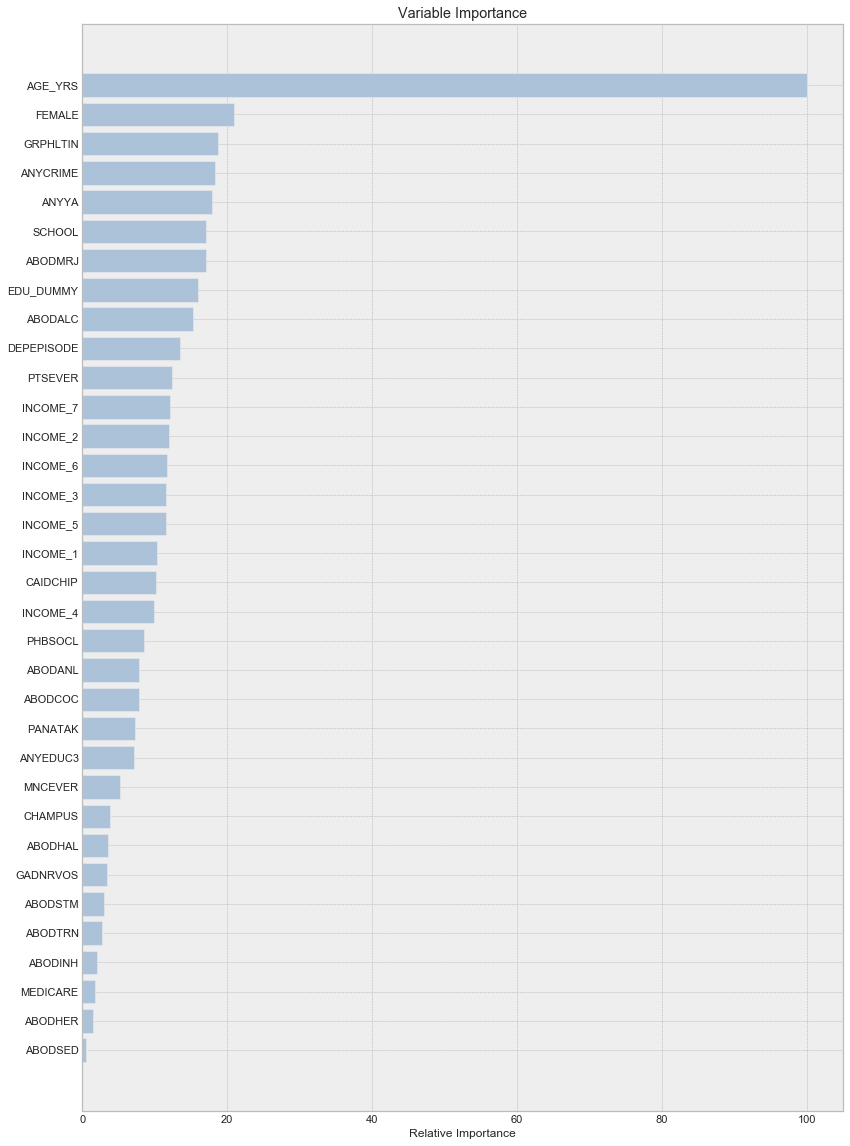

In [72]:
plt.figure(figsize= (30,20))
feature_importance = rfc_o.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'xkcd:cloudy blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Conclusion

Using these results, my intent is to identify potential target populations to focus efforts in combating substance abuse.
The variables with the highest feature importances are implicated the most in determining whether or not the target is satisfied and thus, whether or not an individual receives treatment.


## Model Caveats
- Even after running multiple grid searches, I was not able to get rid of overfitting in my model, whilst maintaining my accuracy score 
    - Train score - 0.9435904290870204 
    - Test score - 0.7963655799037948
- For simplicity’s sake I mainly used summarized variables in my model. More meaning could be extracted by using responses to the more specific questions in the survey
- In accuracies of self reported data


## Further Research

- Looking at the given reasons why an individual did not seek treatment
- Looking at the outcomes of different types of treatment
